<a href="https://colab.research.google.com/github/Pambao/MIP/blob/main/Problem_Set_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question 1:
Implement the Otsu algorithm and apply it for lung segmentation in chest X-rays
(Chest_UoC_paxx.img, these are raw images with the size of 440x440, 16-unsigned bit pixels).
Apply it for lung segmentation in images Chest_HoanMy_xxx. Comment on results.

In [2]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 5.2MB/s 


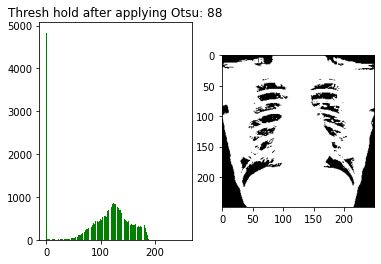

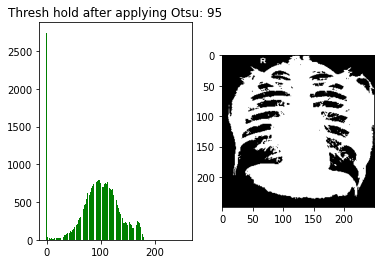

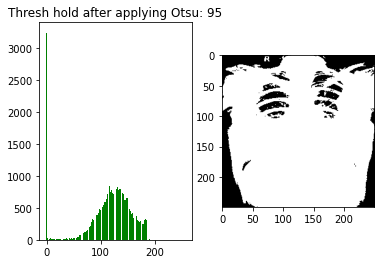

In [11]:
from PIL import Image

import math
import matplotlib.pyplot as plt
import pydicom as dcm

def solution3_1():

    paths = [
        'drive/MyDrive/MIP Resource/Chest_HoanMy_96.jpg',
        'drive/MyDrive/MIP Resource/Chest_HoanMy_97.jpg',
        'drive/MyDrive/MIP Resource/Chest_HoanMy_98.jpg',
    ]

    for path in paths:
        image = Image.open(path)
        image = image.convert('L')
        image = image.resize((250, 250))
        size = image.size
        total_pixel = size[0] * size[1]
        division = range(256)

        histogram = image.histogram()
        thresh_hold = 0
        var_max = 0
        p1 = 0

        plt.subplot(1,2, 1)
        plt.bar(division, histogram, color='green')

        for i in range(256):
            p1 += histogram[i] / total_pixel
            p2 = 1 - p1

            if p1 == 0:
                continue
                
            mean1 = 0
            mean2 = 0
            for x in range(i + 1):
                mean1 += (x * histogram[x] / total_pixel) / p1

            for x in range(i + 1, 256):
                mean2 += (x * histogram[x] / total_pixel) / p2

            var = p1 * p2 * math.pow((mean1 - mean2), 2)

            if var > var_max:
                var_max = var
                thresh_hold = i

        plt.title(f'Thresh hold after applying Otsu: {thresh_hold}')

        for y in range(size[1]):
            for x in range(size[0]):
                val = 0 if image.getpixel((x, y)) < thresh_hold else 255
                image.putpixel((x, y), val)

        plt.subplot(1,2, 2)
        plt.imshow(image, cmap='gray')
        plt.show()

solution3_1()

The result of images after separating the image into 2 classes using Otsu algorithm
can barely highlight the lung region from other parts. The algorithm find the thresh hold
such that the difference of the mean between 2 classes is maximize, then the value of the
pixels in 2 classes are the most distinguished.

## Question 2: 
Develop the algorithms for liver segmentation in MR images.

### Use the fast-marching algorithm only

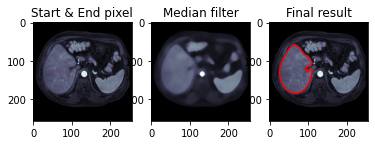

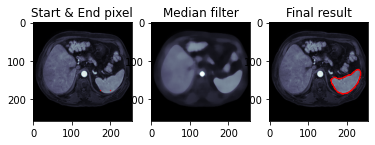

In [14]:
import pydicom as dcm
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.ndimage as filter
import warnings

# Turn off the warning for the notebook
warnings.filterwarnings('ignore')

# The tuple indices for every time insert or popup from Min-heap
TIME = 0
Y = 1
X = 2


# Data structure for storing the neighbor pixel
class MinHeap:
    def __init__(self, image_array):
        self.list = []
        self.position_array = np.ones(image_array.shape)
        self.position_array[:] = -1
        self.sorted = []

    # Arrange the subtree start input is root
    def heapify(self, start):
        left = start * 2 + 1
        right = start * 2 + 2
        min = 0
        length = len(self.list)
        if left < length and right < length:
            min = left if self.list[left][TIME] < self.list[right][TIME] else right
        elif left < length:
            min = left
        elif right < length:
            min = right
        else:
            return
        if self.list[min][TIME] < self.list[start][TIME]:
            a = self.list[start]
            self.list[start] = self.list[min]
            self.list[min] = a
            self.heapify(min)

    # Reconstruct the whole structure
    def reconstruct(self):
        for i in range(int(len(self.list) / 2) - 1, -1, -1):
            self.heapify(i)

    # Pop the smallest val from structure
    def pop(self):
        item = self.list[0]
        del (self.list[0])
        self.reconstruct()
        self.update()
        return item

    """"
    The function check if the time of the pixel has been already in the heap
    If yes, if time_new < time old del time_new else, ignore.
    Otherwise, just insert new val into heap
    """

    def insert(self, pixel):
        pos_in_list = int(self.position_array[pixel[Y], pixel[X]])
        if pos_in_list != -1:
            if pixel[TIME] < self.list[pos_in_list][TIME]:
                del (self.list[pos_in_list])
                self.reconstruct()
                self.update()
            else:
                return

        self.list.append(pixel)
        current = len(self.list) - 1
        parent = int(current / 2 - 0.5)
        while parent >= 0 and current != 0:
            if self.list[current][TIME] < self.list[parent][TIME]:
                a = self.list[parent]
                self.list[parent] = self.list[current]
                self.list[current] = a
                current = parent
                parent = int(current / 2 - 0.5)
            else:
                break
        self.update()

    # Update the position array which store the position of the pixel in the heap structure
    def update(self):
        self.position_array[:] = -1
        for i in range(len(self.list)):
            item = self.list[i]
            self.position_array[item[Y], item[X]] = i


# The function return 2 array of x, y cor gradient array
def gradient(image_array):
    return np.array(np.gradient(image_array))


# The function return 1 array of norm array
def norm(gradient_array):
    return np.sqrt(np.sum(np.square(gradient_array), axis=0))


# The function return 1 array of speed of the image
def speed(image_array, alpha):
    return np.exp(-alpha * norm(gradient(image_array)))


# The function update from neighbor to known to the status array
# 1: known 0: neighbor -1: far
def n2k(status_array, cor):
    status_array[cor[0], cor[1]] = 1


# The function update far to known to the status array
def f2n(status_array, cor):
    y = cor[0]
    x = cor[1]
    if status_array[y, x - 1] == -1:
        status_array[y, x - 1] = 0

    if status_array[y, x + 1] == -1:
        status_array[y, x + 1] = 0

    if status_array[y - 1, x] == -1:
        status_array[y - 1, x] = 0

    if status_array[y + 1, x] == -1:
        status_array[y + 1, x] = 0


# The function initialize the status array
def setup_status(image_array):
    status_array = np.ones(image_array.shape)
    status_array[:] = -1
    return status_array


# The function store the arrival time of the known pixel
def setup_time(image_array):
    time_array = np.ones(image_array.shape)
    time_array[:] = np.inf
    return time_array


# The function calculate the time from the speed value of given pixel
def cal_time(time_array, f_array, cor):
    result = 0
    y = cor[0]
    x = cor[1]
    a = min(time_array[y - 1, x], time_array[y + 1, x])
    b = min(time_array[y, x - 1], time_array[y, x + 1])

    f_ij = f_array[y, x]
    if (1 / f_ij) > abs(a - b):
        result = (a + b + math.sqrt(2 * (1 / f_ij) ** 2 - (a - b) ** 2)) / 2
    else:
        result = (1 / f_ij) ** 2 + min(a, b)

    return result


""""
The function is the whole logic for the algo:
while END pixel is not known:
    1. Pop the smallest time pixel from the heap
    2. Calculate the time for all of its neighbor
    3. Add neighbor to heap (if valid)
    4. n2k
    5. f2n
"""


def liver_segment(image, start, end):
    image_smooth = filter.median_filter(image.pixel_array, 13)
    image_arr = image_smooth

    status = setup_status(image_arr)
    time = setup_time(image_arr)

    # np.set_printoptions(threshold=np.inf, linewidth=140)
    f = speed(image_arr, 2)

    heap = MinHeap(image_arr)
    heap.insert([0, start[1], start[0]])

    # for i in range(7250):
    while status[end[1], end[0]] != 1:
        smallest = heap.pop()

        y = smallest[Y]
        x = smallest[X]
        if (0 < x < image_smooth.shape[0] - 1
                and 0 < y < image_smooth.shape[1] - 1):

            time[y, x] = smallest[TIME]

            t1 = cal_time(time, f, [y - 1, x])
            t2 = cal_time(time, f, [y + 1, x])
            t3 = cal_time(time, f, [y, x - 1])
            t4 = cal_time(time, f, [y, x + 1])

            if status[y - 1, x] != 1:
                heap.insert([t1, y - 1, x])
            if status[y + 1, x] != 1:
                heap.insert([t2, y + 1, x])
            if status[y, x - 1] != 1:
                heap.insert([t3, y, x - 1])
            if status[y, x + 1] != 1:
                heap.insert([t4, y, x + 1])

        f2n(status, [y, x])
        n2k(status, [y, x])

    np.set_printoptions(threshold=np.inf, linewidth=140)

    plt.subplot(1, 3, 1)
    plt.imshow(image.pixel_array, cmap=plt.cm.bone)
    plt.scatter((start[0], end[0]), (start[1], end[1]), c='r', s=0.1)
    plt.title('Start & End pixel')

    plt.subplot(1, 3, 2)
    plt.imshow(image_smooth, cmap=plt.cm.bone)
    plt.title('Median filter')

    plt.subplot(1, 3, 3)
    plt.imshow(image.pixel_array, cmap=plt.cm.bone)
    plt.contour(status, 1, colors='r', linewidths=[1])
    plt.title('Final result')

    plt.show()

if __name__ == '__main__':
    liver_image = dcm.dcmread('drive/MyDrive/MIP Resource/phase1/img0064.dcm')
    start_right = (200, 175)
    end_right = (173, 175)

    start_left = (60, 125)
    end_left = (98, 125)

    liver_segment(liver_image, start_left, end_left)
    liver_segment(liver_image, start_right, end_right)


Fast-marching algorithm is applied on the smooth-image derived from the median-filter algorithm, which smooths the image and reduces noise in the inner part of the liver. The algorithm has a limitation when the border of the object is not cleared enough, which makes the "known" pixel leaked out from the object.